<a href="https://colab.research.google.com/github/ChepChaf/DH-DL/blob/master/Cezar_TP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

*TED* es una organización sin fines de lucro dedicada a difundir ideas, generalmente en forma de conversaciones breves y contundentes. La organización nació en 1984 por iniciativa de Richard Saul Wurman y Harry Marks como una conferencia donde convergieron Tecnología, Entretenimiento y Diseño (de ahí las siglas TED). Actualmente, hay más de 3000 charlas TED disponibles para ver online, las cuales cubren una amplia variedad de temas, desde ciencia hasta negocios y asuntos globales.

Contamos con un dataset que contiene información sobre todas las charlas TED subidas al sitio web oficial hasta el 21 de septiembre de 2017. Entre las variables, se incluyen el número de visualizaciones, el número de comentarios, descripciones, oradores y título de cada disertación. El dataset es de tamaño pequeño, pero tiene algunas particularidades a las que deberán prestarle atención, principalmente la cantidad de información almacenada de forma textual, que será necesario procesar y codificar adecuadamente.

### Objetivos (elegir uno y focalizarse en él):

● Entrenar y optimizar una red neuronal que se capaz de predecir la cantidad de visualizaciones que tendrá una charla en base a la información provista en el dataset.

● Entrenar y optimizar una red neuronal que se capaz de predecir la categoría de una charla en base a la información provista en el dataset.


### Requisitos y material a entregar
La exploración, análisis y modelado de los datos deberán ser entregados en una Jupyter notebook que satisfaga los requerimientos del proyecto. La notebook deberá estar debidamente comentada. Además, los grupos deberán crear un repositorio para el proyecto en Github.

Para la presentación en clase se deben armar algunos slides no técnicos para exponer en no más de 20 minutos (PPT o Google Slides). La presentación debe constar de una introducción (planteo del problema, la pregunta, la descripción del dataset, etc.), un desarrollo de los análisis realizados (análisis descriptivo, análisis de correlaciones preliminares, visualizaciones preliminares) y una exposición de los principales resultados de los modelos y conclusiones.

### Fecha de entrega

● El material deberá entregarse en la clase 13 del curso, día jueves 12 de septiembre.

### Dataset

El dataset contiene información sobre todas las charlas TED subidas al sitio web oficial hasta el 21 de septiembre de 2017. Las variables que se incluyen son:

- comments: el número de comentarios de primer nivel realizados en la charla
- description: una descripción de lo que se habla
- duration: la duración de la charla en segundos
- event: el evento TED/TEDx en el que tuvo lugar la charla
- film_date: el Unix timestamp de la fecha de filmación
- languages: número de lenguajes disponibles de la charla
- main_speaker: nombre del principal orador
- name: nombre oficial de la charla TED
- num_speaker: cantidad de oradores
- published_date: el Unix timestamp de la fecha de publicación
- ratings: un diccionario de las diversas calificaciones otorgadas a la charla (inspiradora, fascinante, asombrosa, etc.)
- related_talks: una lista de diccionarios de charlas recomendadas para ver a continuación
- speaker_occupation: la ocupación del principal orador
- tags: temas asociados a la charla
- title: título de la charla
- url: link al video
- views: cantidad de visualizaciones de la charla

### ¿Cómo empezar? Sugerencias

Agreguen toda otra información construida a partir de los datos originales (o incluso información externa, por ejemplo, las transcripciones de las charlas) que consideren relevante y útil para resolver los objetivos planteados.

El dataset fue publicado en la plataforma Kaggle, una suerte de red social de Data Scientists y practicantes de Machine Learning y Deep Learning. Aprovechen los kernels y discusiones del sitio, comenzar explorando los análisis que ya han hecho otras personas puede ser de mucha ayuda.

En la presentación de los resultados tengan en cuenta que es altamente probable que la audiencia no tenga un nivel técnico, así que mantengan el lenguaje en un nivel accesible.

En términos generales, recuerden las siguientes sugerencias:

● Escribir un pseudocódigo antes de empezar a codear. Suele ser muy útil para darle un esquema y una lógica generales al análisis.

● Leer la documentación de cualquier tecnología o herramienta de análisis que usen. A veces no hay tutoriales para todo y los documentos y las ayudas son fundamentales para entender el funcionamiento de las herramientas utilizadas.

● Documentar todos los pasos, transformaciones, comandos y análisis que realicen.

Recursos útiles

● Documentación de la librería Keras

● Kernel de análisis exploratorio del dataset

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [0]:
from google.colab import files
uploaded = files.upload()

Saving ted_main.csv to ted_main.csv


In [0]:
ted_main = pd.read_csv('./ted_main.csv')
ted_main.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [0]:
transcripts = pd.read_csv('./transcripts.csv')
transcripts.head()

ParserError: ignored

Let's start by seeing if all the  values are present

In [0]:
ted_main.info()

In [0]:
transcripts.info()

The are no null values, but not all of the events have a transcript.

I will investigate the ones that don't have transcript

In [0]:
untranscripted = ted_main[~ted_main['url'].isin(transcripts['url'])]

In [0]:
len(untranscripted)

In [0]:
# Some where musical shows, let's filter those
def is_show(tags):
    entertainment_tags = ['entertainment', 'guitar', 'music', 'performance']
    
    for x in entertainment_tags:
        if x in tags: return True
    return False
non_entertainment = untranscripted[~untranscripted['tags'].apply(lambda x: is_show(x))]

In [0]:
len(non_entertainment)

There are 60 talks without transcripts, if we decide to use the transcripts to train the model we will have to remove those talks

I will assume that some features aren't important for any of our tasks:
- event: Unique ID not relevant for now, except that we start crossing data with other sources
- url: ID
- ratings: We won't have that feature for new talks
- related_talks: may be usefull but not for now
- cooments: Won't have that for new talks

In [0]:
reduced_X = ted_main.drop(['event', 'url', 'ratings', 'related_talks', 'comments'], axis=1)
reduced_X.head()

Let's map duration and languages correlation to views

In [0]:
sns.scatterplot(x=ted_main['duration'], y=ted_main['views'])

In [0]:
sns.scatterplot(x=ted_main['languages'], y=ted_main['views'])

The number of languages may have a little correlation to views but nothing to considerably.

The same with talks that are too long.

In [0]:
sns.catplot(x='num_speaker', y='views', data=ted_main)

Not many talks have more than one speaker, and those don't seem to do very good

Tags to columns:

In [0]:
# Start by getting all the tags
tag_ocurrences = ted_main['tags'].apply(lambda x: pd.eval(x, engine='python')).apply(pd.Series).stack().value_counts()
print(tag_ocurrences)

technology           727
science              567
global issues        501
culture              486
TEDx                 450
design               418
business             348
entertainment        299
health               236
innovation           229
society              224
art                  221
social change        218
future               195
communication        191
creativity           189
biology              189
humanity             182
collaboration        174
environment          165
economics            164
medicine             162
brain                158
activism             157
education            153
community            148
history              146
children             143
TED Fellows          143
invention            140
                    ... 
glacier                4
jazz                   4
nuclear weapons        4
urban                  4
ants                   4
vulnerability          4
microfinance           4
sleep                  4
epidemiology           3


In [0]:
# Let's drop tags with 25 or less ocurrences
tag_list = tag_ocurrences[tag_ocurrences > 150].index.values
tag_list

array(['technology', 'science', 'global issues', 'culture', 'TEDx',
       'design', 'business', 'entertainment', 'health', 'innovation',
       'society', 'art', 'social change', 'future', 'communication',
       'creativity', 'biology', 'humanity', 'collaboration',
       'environment', 'economics', 'medicine', 'brain', 'activism',
       'education'], dtype=object)

In [0]:
def tag_list_to_df(tags, tag_list):
    row = []
    for tag in tag_list:
        row.append(1 if tag in tags else 0)
    return pd.Series(row)

In [0]:
tags = pd.DataFrame(
    ted_main['tags'].apply(lambda x: tag_list_to_df(x, tag_list)))
tags.columns = tag_list
X_with_tags = ted_main.drop('tags', axis=1).join(tags)

In [0]:
X_with_tags.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'title', 'url',
       'views', 'technology', 'science', 'global issues', 'culture', 'TEDx',
       'design', 'business', 'entertainment', 'health', 'innovation',
       'society', 'art', 'social change', 'future', 'communication',
       'creativity', 'biology', 'humanity', 'collaboration', 'environment',
       'economics', 'medicine', 'brain', 'activism', 'education'],
      dtype='object')

In [0]:
X = X_with_tags.drop(['comments', 'description', 'event', 'film_date', 'main_speaker', 'name',
                     'published_date', 'ratings', 'related_talks', 'speaker_occupation',
                     'title', 'url', 'views'], axis=1)
y = X_with_tags['views']

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (2040, 28)
y_train shape:  (2040,)
X_test shape:  (510, 28)
y_test shape:  (510,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_log_train = np.log(y_train.values)
y_log_test = np.log(y_test.values)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

Using TensorFlow backend.
W0829 23:36:02.815179 140570064955264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 23:36:02.858227 140570064955264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 23:36:02.865142 140570064955264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 23:36:02.889862 140570064955264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

In [0]:
rmsprop = RMSprop(lr=0.0015)

In [0]:
model.compile(optimizer=rmsprop, loss='mean_squared_logarithmic_error', metrics=['mae'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               14848     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [0]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [0]:
model.fit(X_train, y_log_train, epochs=5000, batch_size=4, validation_split=0.2, callbacks=[es])

Train on 1632 samples, validate on 408 samples
Epoch 1/5000
1632/1632 [==============================] - 4s 2ms/step - loss: 0.0444 - mean_absolute_error: 2.4352 - val_loss: 0.0760 - val_mean_absolute_error: 3.5699
Epoch 2/5000
1632/1632 [==============================] - 3s 2ms/step - loss: 0.0296 - mean_absolute_error: 2.0925 - val_loss: 0.0364 - val_mean_absolute_error: 2.5274
Epoch 3/5000
1632/1632 [==============================] - 3s 2ms/step - loss: 0.0273 - mean_absolute_error: 1.9574 - val_loss: 0.0103 - val_mean_absolute_error: 1.2380
Epoch 4/5000
1632/1632 [==============================] - 3s 2ms/step - loss: 0.0290 - mean_absolute_error: 2.0379 - val_loss: 0.0584 - val_mean_absolute_error: 3.1588
Epoch 5/5000
1632/1632 [==============================] - 3s 2ms/step - loss: 0.0338 - mean_absolute_error: 2.1715 - val_loss: 0.0280 - val_mean_absolute_error: 2.2084
Epoch 6/5000
1632/1632 [==============================] - 3s 2ms/step - loss: 0.0267 - mean_absolute_error: 1.927

In [0]:
model.evaluate(X_test, y_log_test)

510/510 [==============================] - 0s 93us/step


[0.0015330498645483863, 0.4586951307221955]

In [0]:
predicted = pd.Series(model.predict(X_test).flatten())

In [0]:
comp = pd.DataFrame({'predicted': np.exp(predicted), 'real_log': pd.Series(np.exp(y_log_test))})

In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [0]:
comp.head(10)

,predicted,real_log
0,1534747.500,1546610.000
1,1942557.625,1072306.000
2,763102.688,1527858.000
3,1772962.875,932561.000
4,2413065.000,2459753.000
5,899853.875,1252289.000
6,3519413.250,3450119.000
7,1014672.250,1415724.000
8,1266008.000,780116.000
9,560422.562,739690.000


In [0]:
comp.describe()

,predicted,real_log
count,510.000,510.000
mean,1364132.750,1878140.847
std,964594.250,2951806.927
min,260341.984,120274.000
25%,882788.281,752167.250
50%,1181603.625,1138817.000
75%,1534986.844,1804856.750
max,12240924.000,34309432.000


In [0]:
comp[comp['real_log'] == comp['real_log'].max()]

,predicted,real_log
372,6787852.500,34309432.000


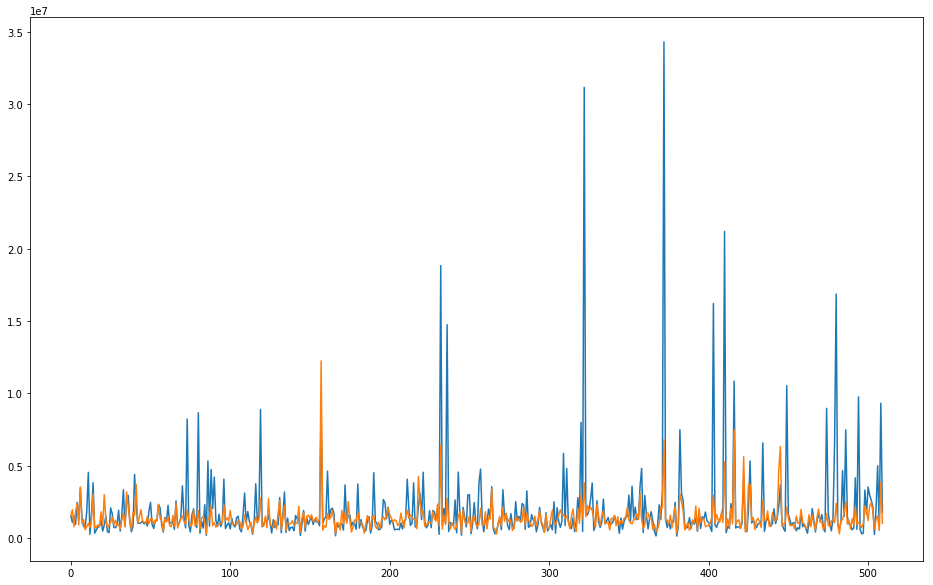

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))
sns.lineplot(data=comp['real_log'])
sns.lineplot(data=comp['predicted'])

Let's convert title and description

In [0]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

speakers = list(set(X_with_tags['main_speaker'].values))
extra_stop_words = ['ted', 'talk', 'talks', 'don']
stop_words[:10]

stop_words = speakers + list(ENGLISH_STOP_WORDS) + extra_stop_words

In [0]:
X_with_tags['title-description'] = X_with_tags['title'].str.lower().cat(X_with_tags['description'].str.lower(), sep=' ')

AttributeError: ignored

In [0]:
len(set(X_with_tags['title-description'].str.cat(sep=' ').split()))

26414

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(min_df=0.02 ,max_df=0.8, stop_words=stop_words)
title_words = vec.fit_transform(X_with_tags['title-description'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aakash', 'aala', 'aamodt', 'aaron', 'aaronson', 'abani', 'abdel', 'abdi', 'abdul', 'abe', 'abha', 'abigail', 'abouelnaga', 'abraham', 'abrahams', 'abramović', 'abrams', 'abreu', 'abu', 'acaroglu', 'achenyo', 'achor', 'acquisti', 'adam', 'adami', 'adams', 'addis', 'adegbeye', 'adele', 'adichie', 'aditi', 'adora', 'aduaka', 'afra', 'agarawala', 'agarwal', 'agassi', 'aglio', 'agra', 'agrawal', 'agus', 'agüera', 'ahmad', 'ahn', 'aicha', 'aiden', 'aimee', 'aj', 'ajit', 'akyol', 'al', 'alaa', 'alain', 'alan', 'alanna', 'alastair', 'alberto', 'albright', 'alcorn', 'alec', 'alejandro', 'alemseged', 'aleph', 'alessandra', 'alessandro', 'alex', 'alexa', 'alexander', 'alexis', 'ali', 'alice', 'alicia', 'alisa', 'alison', 'alix', 'allan', 'allende', 'allison', 'allocca', 'almog', 'alon', 'alter', 'altma

In [0]:
title_df = pd.DataFrame(data= title_words.todense(), columns = vec.get_feature_names())

In [0]:
title_df.head()

,actually,art,artist,asks,author,beautiful,best,better,big,body,bold,brain,bring,build,building,calls,case,change,city,come,community,complex,country,create,creative,culture,data,david,day,deep,describes,design,designer,different,disease,does,earth,end,energy,experience,...,short,shows,simple,social,start,stories,story,studies,suggests,surprising,takes,team,technology,tell,tells,things,think,thinking,time,today,understand,use,uses,using,ve,video,vision,want,war,watch,way,ways,women,work,working,works,world,year,years,young
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.589,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.431,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.459,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.383,0.000,0.000,0.000,0.354,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.366,0.000,0.342,0.000,0.000,0.374,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.396,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.781,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.219,0.000,0.000,0.000
